* OpenCV Selective Search Example :: <https://www.learnopencv.com/selective-search-for-object-detection-cpp-python/>

In [8]:
import cv2
import os
import random
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import patches
import xml.etree.ElementTree as ET
import xmltodict
import re

%matplotlib inline

In [3]:
# Using Oxfold Pet Dataset
ROOT_DIR = os.path.abspath('./')
DATA_ROOT = os.path.join(ROOT_DIR, '/data/Oxford_Pet_Dataset')
ANN_DIR = os.path.join(DATA_ROOT, 'annotations/xmls')
IMG_DIR = os.path.join(DATA_ROOT, 'images')

annotations = sorted(os.listdir(ANN_DIR))

In [4]:
# Display Dataset Structure
%cd $DATA_ROOT
!tree --dirsfirst --filelimit 10
%cd $ROOT_DIR

/home/jihunjung/Oxford-IIIT_dataset
.
├── annotations
│   ├── trimaps [7390 entries exceeds filelimit, not opening dir]
│   ├── xmls [3686 entries exceeds filelimit, not opening dir]
│   ├── README
│   ├── list.txt
│   ├── test.txt
│   └── trainval.txt
├── images [7393 entries exceeds filelimit, not opening dir]
├── annotations.tar.gz
└── images.tar.gz

4 directories, 6 files
/home/jihunjung/deeplearning_research/research_note/object_detection/RCNN


In [5]:
def GetImageInformation(ann_file):
    # Read annotation file(*.xml)
    xmls = os.path.join(ANN_DIR, ann_file)
    ann = xmltodict.parse(open(xmls, 'rb'))['annotation']
    
    # Image Load
    image_file = ann['filename']
    img = cv2.imread(os.path.join(IMG_DIR, image_file))

    # Get Ground Truth Information
    x1 = int(ann['object']['bndbox']['xmin'])
    y1 = int(ann['object']['bndbox']['ymin'])
    x2 = int(ann['object']['bndbox']['xmax'])
    y2 = int(ann['object']['bndbox']['ymax'])

    gt_bbox = np.array([x1, y1, x2-x1, y2-y1])
    
    obj_type = ann['object']['name']
    
    obj_name = os.path.splitext(image_file)[0]
    obj_name = " ".join(re.findall("[a-zA-Z]+", obj_name))
    
    return img, gt_bbox, obj_name

In [6]:
def SelectiveSearch(img):
    # Selective Search
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    ssresults = ss.process()
    print('Proposed Region :: {}'.format(len(ssresults)))
    
    return ssresults

In [7]:
def ComputeIOU(gt, p):
    x1 = np.maximum(gt[0], p[:, 0])
    y1 = np.maximum(gt[1], p[:, 1])
    x2 = np.minimum(gt[0] + gt[2], p[:, 0] + p[:, 2])
    y2 = np.minimum(gt[1] + gt[3], p[:, 1] + p[:, 3])

    intersection = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)
    gt_area = gt[2] * gt[3]
    propoesed_area = p[:, 2] * p[:, 3]
    union = gt_area + propoesed_area[:] - intersection[:]

    iou = intersection/union
    
    return iou

In [8]:
def GenerateFinalRegion(gt_bbox, rp):
    # Generate pos, neg region
    iou_results = ComputeIOU(gt_bbox, rp)
    
    positive = np.array([], dtype=np.int32).reshape(0, 4)
    negative = np.array([], dtype=np.int32).reshape(0, 4)
   
    pos_cnt = 0
    neg_cnt = 0
       
    for idx, iou in enumerate(iou_results):
        if idx < 2000:
            # positive
            if iou >= 0.5 and pos_cnt < 30:
                positive = np.vstack([positive, rp[idx]])
                pos_cnt += 1

            # negative
            elif iou <= 0.3 and neg_cnt < 30:
                negative = np.vstack([negative, rp[idx]])
                neg_cnt += 1
        else:
            break
    
    return positive, negative

In [9]:
def DrawRegion(bboxes, title='Empty', color='magenta', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(10, 10))
    
    # BBox Display
    for bbox in bboxes:
        x, y, w, h = bbox
        p = patches.Rectangle((x, y), w, h, linewidth=2, alpha=1.0, linestyle="solid", edgecolor=color, facecolor='none')
        ax.add_patch(p)

    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.axis('off')
    ax.set_title(title)


In [10]:
def VisualizeRegion(img, rp):
    imgs = []

    for i in rp:
        x, y, w, h = i
        roi_img = img[y:y+h, x:x+w]
        re_img = cv2.resize(roi_img, (224,224), interpolation = cv2.INTER_AREA)
        imgs.append(re_img)

    rows = 5
    cols = 5
    length = rows * cols
    
    print('Number of Region ::', len(imgs))

    fig = plt.figure(figsize=(8, 8))
    tmp_img = np.full((224, 224, 3), 255)
        
    for i in range(length):
        plt.subplot(rows, cols,i+1)
        plt.axis('off')
        new_img = cv2.cvtColor(imgs[i], cv2.COLOR_BGR2RGB) if i < len(imgs) else tmp_img
        plt.imshow(new_img)
    plt.tight_layout()
    

In [17]:
# ann_file = 'pomeranian_103.xml'
ann_file = random.choice(annotations)

img, gt_bbox, obj_name = GetImageInformation(ann_file)
print('Category Name :: {}'.format(obj_name))

rp = SelectiveSearch(img)
pos, neg = GenerateFinalRegion(gt_bbox, rp)


Category Name :: newfoundland
Proposed Region :: 798


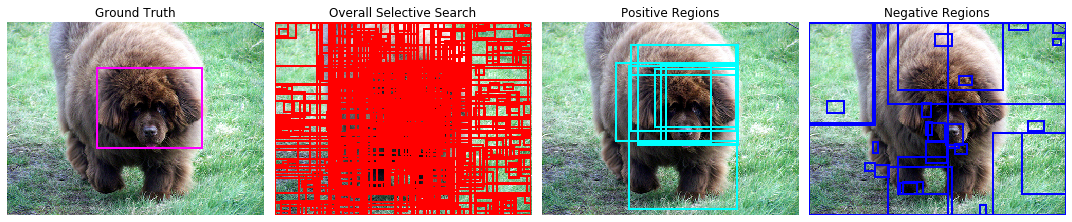

In [18]:
_, ax = plt.subplots(1, 4, figsize=(15, 15))

# Display Ground Truth
DrawRegion(np.array([gt_bbox]), title='Ground Truth', ax=ax[0])

# Display Overall Selective Search
DrawRegion(rp, title='Overall Selective Search', color='red', ax=ax[1])

# Display Positive Region
DrawRegion(pos, title='Positive Regions',  color='cyan', ax=ax[2])

# Display Negitive Region
DrawRegion(neg, title='Negative Regions', color='blue', ax=ax[3])

plt.tight_layout()

Number of Region :: 14


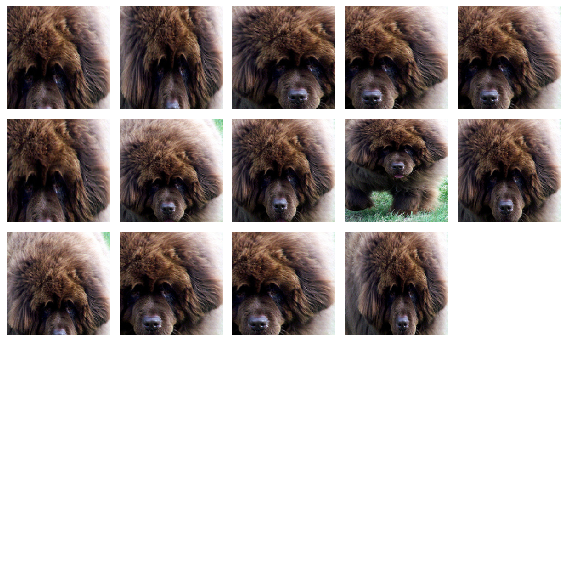

In [19]:
# Visualize Positive Region
VisualizeRegion(img, pos)

Number of Region :: 30


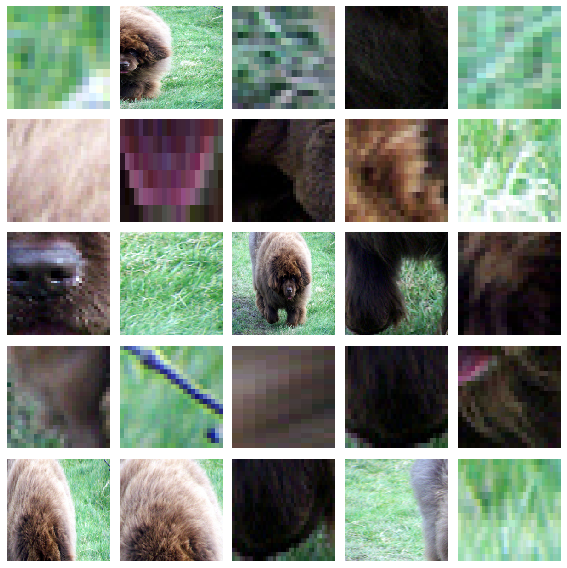

In [20]:
# Visualize Negative Region
VisualizeRegion(img, neg)

### Reference :: <https://towardsdatascience.com/step-by-step-r-cnn-implementation-from-scratch-in-python-e97101ccde55>